In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 환경 설정 및 데이터 준비

## 1.1 라이브러리 임포트

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, GRU, concatenate, AveragePooling1D
)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## 1.2 데이터 로드 헬퍼 함수 정의

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

## 1.3 데이터 로드 및 검증 세트 분리

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
# 3D 데이터를 스케일링하기 위해 (samples, timesteps, features) -> (samples * timesteps, features) 2D로 변환
n_features = X_train.shape[2]
X_train_2d = X_train.reshape(-1, n_features)
X_val_2d = X_val.reshape(-1, n_features)
testX_2d = testX.reshape(-1, n_features)

In [9]:
# Train 데이터 기준으로 스케일러 피팅
scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
testX_scaled_2d = scaler.transform(testX_2d)

In [10]:
# 다시 3D (samples, timesteps, features) 형태로 복원
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
testX_scaled = testX_scaled_2d.reshape(testX.shape)

In [11]:
print("Scaling completed. Scaled Train Shape:", X_train_scaled.shape)

Scaling completed. Scaled Train Shape: (5881, 128, 9)


# 2. 모델 정의

## 2.1 모델 파라미터 설정

In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [45]:
# 공통 학습 파라미터
EPOCHS = 200
BATCH_SIZE = 64

# 입력 형태 정의
input_shape = (n_timesteps, n_features)

## 2.2 CNN 모델 정의

In [55]:
def build_cnn_model():
    inputs = Input(shape=input_shape, name="Input_CNN")
    reg = l2(1e-4) # L2 규제 인스턴스

    # Level_1
    conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=reg)(inputs)
    conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=reg)(inputs)
    conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=reg)(inputs)
    conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu', kernel_regularizer=reg)(inputs)
    merged_1 = concatenate([conv1_1, conv1_2, conv1_3, conv1_4], axis=1)
    pool_1 = MaxPooling1D(pool_size=3)(merged_1)
    pool_1 = Dropout(0.4)(pool_1) # [수정] 0.3 -> 0.4

    # Level_2
    conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=reg)(pool_1)
    conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=reg)(pool_1)
    conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu', kernel_regularizer=reg)(pool_1)
    conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu', kernel_regularizer=reg)(pool_1)
    merged_2 = concatenate([conv2_1, conv2_2, conv2_3, conv2_4], axis=1)
    pool_2 = MaxPooling1D(pool_size=3)(merged_2)
    pool_2 = Dropout(0.4)(pool_2) # [수정] 0.3 -> 0.4

    # Level_3
    conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=reg)(pool_2)
    conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=reg)(pool_2)
    conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu', kernel_regularizer=reg)(pool_2)
    conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu', kernel_regularizer=reg)(pool_2)
    merged_3 = concatenate([conv3_1, conv3_2, conv3_3, conv3_4], axis=1)
    pool_3 = MaxPooling1D(pool_size=3)(merged_3)
    pool_3 = Dropout(0.4)(pool_3) # [수정] 0.3 -> 0.4

    # Classifier
    flat_cnn = Flatten()(pool_3)
    dense = Dense(512, activation='relu', kernel_regularizer=reg)(flat_cnn)
    dense = Dropout(0.6)(dense) # [수정] 0.5 -> 0.6
    outputs = Dense(n_outputs, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3. 모델 빌드

In [56]:
model_cnn = build_cnn_model()

In [57]:
model_cnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_CNN           │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 126, 128)  │      3,584 │ Input_CNN[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 124, 128)  │      5,888 │ Input_CNN[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 122, 128)  │      8,192 │ Input_CNN[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 120, 128)  │     10,496 │ Input_CNN[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 492, 128)  │          0 │ conv1d_52[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_53[0][0],  │
│                     │                   │            │ conv1d_54[0][0],  │
│                     │                   │            │ conv1d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 164, 128)  │          0 │ concatenate_13[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 164, 128)  │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 162, 64)   │     24,640 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 160, 64)   │     41,024 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 158, 64)   │     57,408 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 156, 64)   │     73,792 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 636, 64)   │          0 │ conv1d_56[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_57[0][0],  │
│                     │                   │            │ conv1d_58[0][0],  │
│                     │                   │            │ conv1d_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 212, 64)   │          0 │ concatenate_14[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 212, 64)   │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 210, 32)   │      6,176 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 208, 32)   │     10,272 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 206, 32)   │     14,368 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 204, 32)   │     18,464 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,799,878 (18.31 MB)

 Trainable params: 4,799,878 (18.31 MB)

 Non-trainable params: 0 (0.00 B)

# 4. 모델 학습

In [58]:
# Callbacks 정의
# 15 Epochs 동안 val_loss가 개선되지 않으면 학습 중단 및 최적 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# 5 Epochs 동안 val_loss가 개선되지 않으면 학습률을 0.2배로 감소
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

In [59]:
history = model_cnn.fit(
    X_train_scaled,
    y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_one_hot),
    verbose=2,
    callbacks=callbacks
)

Epoch 1/200
92/92 - 22s - 236ms/step - accuracy: 0.5395 - loss: 1.6799 - val_accuracy: 0.8838 - val_loss: 0.5169 - learning_rate: 1.0000e-03
Epoch 2/200
92/92 - 1s - 16ms/step - accuracy: 0.9179 - loss: 0.3770 - val_accuracy: 0.9368 - val_loss: 0.3045 - learning_rate: 1.0000e-03
Epoch 3/200
92/92 - 1s - 15ms/step - accuracy: 0.9471 - loss: 0.2855 - val_accuracy: 0.9538 - val_loss: 0.2679 - learning_rate: 1.0000e-03
Epoch 4/200
92/92 - 1s - 15ms/step - accuracy: 0.9490 - loss: 0.2673 - val_accuracy: 0.9538 - val_loss: 0.2627 - learning_rate: 1.0000e-03
Epoch 5/200
92/92 - 1s - 14ms/step - accuracy: 0.9510 - loss: 0.2593 - val_accuracy: 0.9538 - val_loss: 0.2614 - learning_rate: 1.0000e-03
Epoch 6/200
92/92 - 1s - 15ms/step - accuracy: 0.9529 - loss: 0.2451 - val_accuracy: 0.9545 - val_loss: 0.2411 - learning_rate: 1.0000e-03
Epoch 7/200
92/92 - 1s - 15ms/step - accuracy: 0.9514 - loss: 0.2425 - val_accuracy: 0.9531 - val_loss: 0.2385 - learning_rate: 1.0000e-03
Epoch 8/200
92/92 - 1s - 

# 4. 결과 분석 및 평가

## 4.1 학습 과정 시각화 (Loss & Accuracy)

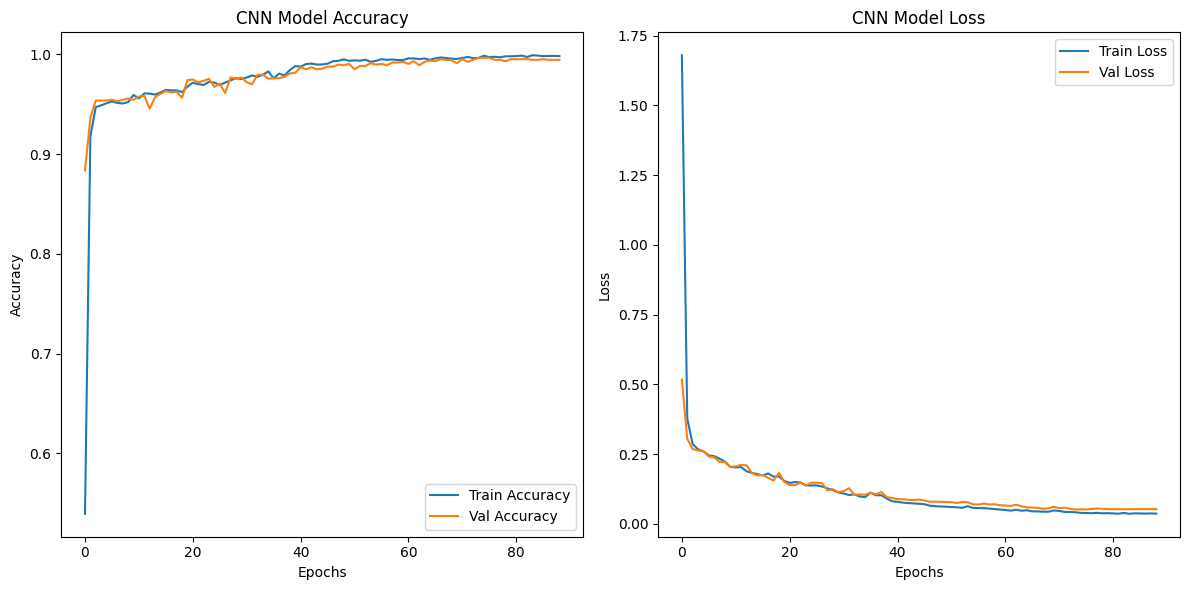

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 테스트 세트 평가 (Confusion Matrix)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accuracy: 0.9250

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.99      0.95      0.97       471
           2       0.90      1.00      0.95       420
           3       0.83      0.81      0.82       491
           4       0.85      0.88      0.86       532
           5       0.99      0.97      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



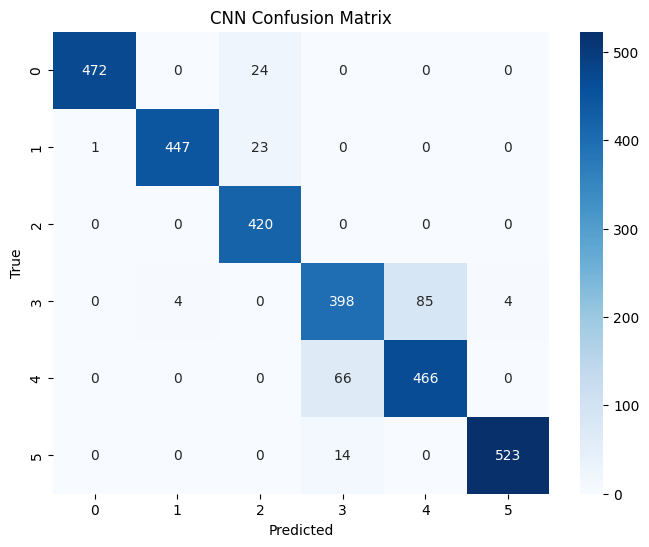

In [61]:
pred_probs = model_cnn.predict(testX_scaled)
pred_classes = np.argmax(pred_probs, axis=-1)

print(f"Accuracy: {accuracy_score(testy, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(testy, pred_classes))

cm = confusion_matrix(testy, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()